# BERT text sentiment model

In [ ]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import time

import torch
from torch import optim
from torch.nn import functional as F
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    TensorDataset,
    SequentialSampler,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
)
import random

from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
from torchview import draw_graph


BERT_MODEL = "DeepPavlov/rubert-base-cased"
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 32
DATASET_PATH = "../data/lemmatize_labeled_rusentiment_text_mystem.csv"
N_SAMPLES = 100000
NUM_CLASSES = 3
BERT_OUTPUT = 32

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Доступные GPU устройства: {torch.cuda.device_count()}")
    print(f"Используемое GPU устройство: {torch.cuda.get_device_name()}")
    print(torch.cuda.memory_summary())
else:
    print("Доступных GPU нет")
    device = torch.device("cpu")

Доступные GPU устройства: 1
Используемое GPU устройство: NVIDIA GeForce RTX 3070 Ti
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       

In [5]:
torch.cuda.empty_cache()

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

In [7]:
def transform_sentences(sentences: list) -> tuple:
    input_ids = []
    attention_masks = []
    for sentence in tqdm(sentences):
        encoded_dict = bert_tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_SEQ_LENGTH,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [8]:
data = pd.read_csv(DATASET_PATH)
data.head()

,text,sentiment
0,украина это часть русь искусственно отделять к...,negative
1,говорить относительно небольшой коррупция обра...,negative
2,свой поляк сделать русский понятно литовский п...,neutral
3,фильм зритель любить диковинный соседка пятый ...,neutral
4,государство платить посмотреть денежный поток ...,negative


In [9]:
data = data.drop_duplicates(subset=["text"])

In [10]:
data.isnull().sum()

text         1
sentiment    0
dtype: int64

In [11]:
data = data.dropna(subset=["text"]).sample(frac=1).reset_index(drop=True)

In [12]:
label_encoder = LabelEncoder()
label_encoder.fit(data["sentiment"])

LabelEncoder()

In [13]:
label_encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [14]:
data["sentiment"] = label_encoder.transform(data["sentiment"])

In [15]:
data["sentiment"].value_counts()

2    168410
0    147945
1     25893
Name: sentiment, dtype: int64

In [16]:
data.head()

,text,sentiment
0,склоняться присед блеать,2
1,снаступающимтвиттерский единорог новый,0
2,шикарный пижама доходить месяц,2
3,хотеть сделать снеговик везти снег лепиться за...,2
4,футболка понравиться сожаление оказываться мал...,2


In [17]:
if N_SAMPLES:
    data = data.sample(N_SAMPLES)

In [18]:
train_df, test_df = train_test_split(data, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.2)

In [19]:
train_input_ids, train_attention_masks = transform_sentences(train_df["text"].to_list())
train_labels = F.one_hot(torch.tensor(train_df["sentiment"].to_list()).to(torch.int64)).to(torch.float64)

  0%|          | 0/64000 [00:00<?, ?it/s]C:\Users\Dmitry\anaconda3\envs\vkr\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 64000/64000 [01:09<00:00, 927.20it/s] 


In [20]:
valid_input_ids, valid_attention_masks = transform_sentences(valid_df["text"].to_list())
valid_labels = F.one_hot(torch.tensor(valid_df["sentiment"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 16000/16000 [00:16<00:00, 961.70it/s] 


In [21]:
test_input_ids, test_attention_masks = transform_sentences(test_df["text"].to_list())
test_labels = F.one_hot(torch.tensor(test_df["sentiment"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 20000/20000 [00:20<00:00, 980.74it/s] 


In [22]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [23]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=RandomSampler(train_dataset),
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    sampler=SequentialSampler(valid_dataset),
)
test_dataloader = DataLoader(test_dataset)

In [24]:
def f1_weighted_score(preds: torch.Tensor, labels: torch.Tensor):
    pred_numpy = preds.cpu().detach().numpy()
    labels_numpy = labels.cpu().detach().numpy()
    pred_flatten = np.argmax(pred_numpy, axis=1).flatten()
    labels_flatten = np.argmax(labels_numpy, axis=1).flatten()
    return f1_score(labels_flatten.astype(np.int32), pred_flatten.astype(np.int32), average="weighted")

In [25]:
bert_model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL,
    num_labels=BERT_OUTPUT,
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [26]:
class TextSentimentModel(torch.nn.Module):

    def __init__(self, num_classes: int, language_model, language_model_dim: int):
        super().__init__()
        self.language_model = language_model
        self.classifier = torch.nn.Linear(
            in_features=language_model_dim,
            out_features=num_classes,
        )
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        language_output = self.language_model(
            input_ids,
            token_type_ids=None,
            attention_mask=attention_mask,
        ).logits
        logits = self.softmax(self.classifier(language_output))
        return logits

In [27]:
text_sentiment_model = TextSentimentModel(
    num_classes=NUM_CLASSES,
    language_model=bert_model,
    language_model_dim=BERT_OUTPUT,
)
text_sentiment_model.to(device)

TextSentimentModel(
  (language_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

In [28]:
LEARNING_RATE = 2e-6
EPS = 1e-8
NUM_EPOCHS = 10

NUM_WARMUP_STEPS = 0
NUM_TRAINING_STEPS = len(train_dataloader) * NUM_EPOCHS


In [29]:
optimizer = torch.optim.AdamW(text_sentiment_model.parameters(), lr=LEARNING_RATE, eps=EPS)
loss_function = torch.nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=NUM_TRAINING_STEPS,
)

In [30]:
def plot_history(history: dict) -> None:
    train = history.get("train")
    valid = history.get("valid")
    plt.title("Loss")
    plt.plot(train.get("loss"), label="train")
    plt.plot(valid.get("loss"), label="valid")
    plt.legend()
    plt.show()
    plt.title("Accuracy")
    plt.plot(train.get("accuracy"), label="train")
    plt.plot(valid.get("accuracy"), label="valid")
    plt.legend()
    plt.show()

In [31]:
def train(
        model: torch.nn.Module,
        dataloader: DataLoader,
        optim: optim.Optimizer,
        loss_func: torch.nn.Module,
        warmup_scheduler=None,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.train()
    for input_ids, attention_mask, sentiment in dataloader:
        optim.zero_grad()

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        sentiment = sentiment.to(device)

        logits = model(input_ids, attention_mask)

        loss_current = loss_func(logits.to(device), sentiment)

        accuracy_curr = f1_weighted_score(logits, sentiment)

        loss_current.backward()
        optim.step()
        if warmup_scheduler:
            warmup_scheduler.step()

        loss += loss_current.item()
        accuracy += accuracy_curr.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [32]:
def validate(
        model: torch.nn.Module,
        dataloader: DataLoader,
        loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, sentiment in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            sentiment = sentiment.to(device)

            logits = model(input_ids, attention_mask)

            loss_current = loss_func(logits.to(device), sentiment)

            accuracy_current = f1_weighted_score(logits, sentiment)

            loss += loss_current.item()
            accuracy += accuracy_current.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [33]:
def training(
        model: torch.nn.Module,
        train_data: DataLoader,
        validate_data: DataLoader,
        optim: optim.Optimizer,
        loss_func: torch.nn.Module,
        num_epochs: int = 10,
        warmup_scheduler=None,
) -> Dict[str, Any]:
    best_loss = float('inf')
    history = {
        "train": {
            "loss": [],
            "accuracy": [],
        },
        "valid": {
            "loss": [],
            "accuracy": [],
        }
    }
    for epoch in range(num_epochs):
        print(f"{'=' * 15} Epoch: {epoch + 1} {'=' * 15}")
        time_start = time.time()
        train_loss, train_accuracy = train(model, train_data, optim, loss_func, warmup_scheduler)
        print(f"Train: loss={train_loss:.3f}, accuracy={train_accuracy:.3f}")
        validation_loss, validation_accuracy = validate(model, validate_data, loss_func)
        print(f"Validation: loss={validation_loss:.3f}, accuracy={validation_accuracy:.3f}")
        time_end = time.time()
        time_delta = time_end - time_start
        if validation_loss < best_loss:
            best_loss = validation_loss
        history["train"]["accuracy"].append(train_accuracy)
        history["train"]["loss"].append(train_loss)
        history["valid"]["accuracy"].append(validation_accuracy)
        history["valid"]["loss"].append(validation_loss)
        print(f"Time elapsed: {time_delta:.2f} s\n{'=' * 40}")
    return history


(process:13880): Pango-WARNING **: 19:07:24.374: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:16196): Pango-WARNING **: 19:07:24.951: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


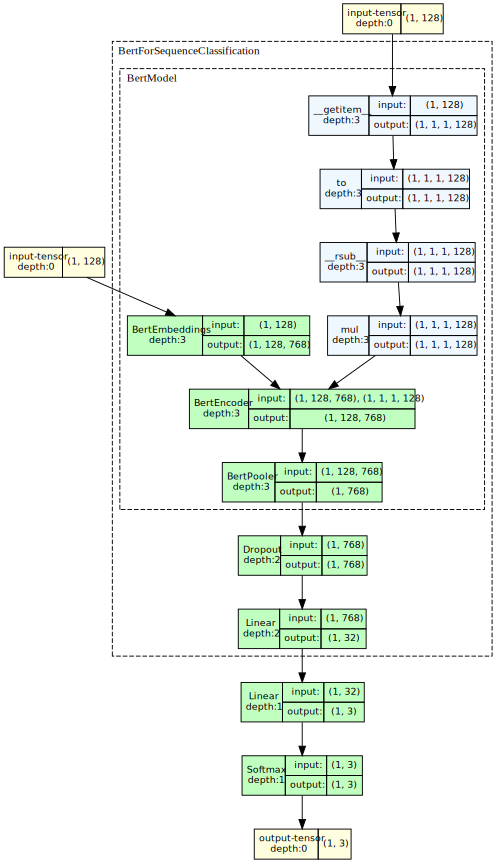

In [35]:
from torchview import draw_graph

model_graph = draw_graph(
    text_sentiment_model,
    input_data=(test_input_ids[:1], test_attention_masks[:1]),
    expand_nested=True,
    save_graph=True,
    filename="text_sentiment_model",
)
model_graph.visual_graph

In [32]:
language_model_history = training(
    text_sentiment_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_function,
    num_epochs=NUM_EPOCHS,
)

=============== Epoch: 1 ===============
Train: loss=0.903, accuracy=0.627
Validation: loss=0.858, accuracy=0.682
Time elapsed: 765.43 s
=============== Epoch: 2 ===============
Train: loss=0.845, accuracy=0.694
Validation: loss=0.848, accuracy=0.691
Time elapsed: 757.55 s
=============== Epoch: 3 ===============
Train: loss=0.827, accuracy=0.714
Validation: loss=0.841, accuracy=0.700
Time elapsed: 756.64 s
=============== Epoch: 4 ===============
Train: loss=0.814, accuracy=0.728
Validation: loss=0.839, accuracy=0.701
Time elapsed: 754.80 s
=============== Epoch: 5 ===============
Train: loss=0.804, accuracy=0.740
Validation: loss=0.836, accuracy=0.706
Time elapsed: 746.09 s
=============== Epoch: 6 ===============
Train: loss=0.792, accuracy=0.754
Validation: loss=0.839, accuracy=0.703
Time elapsed: 745.77 s
=============== Epoch: 7 ===============
Train: loss=0.782, accuracy=0.764
Validation: loss=0.837, accuracy=0.705
Time elapsed: 741.28 s
=============== Epoch: 8 ===============


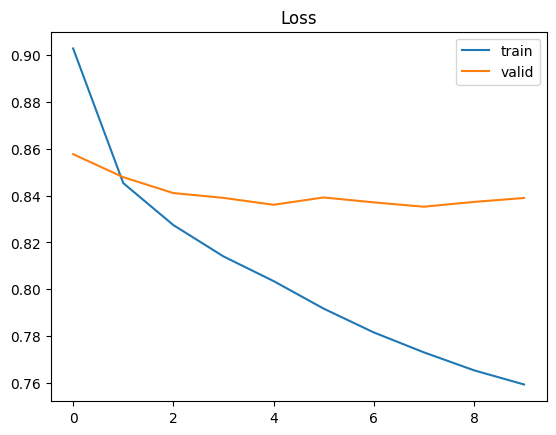

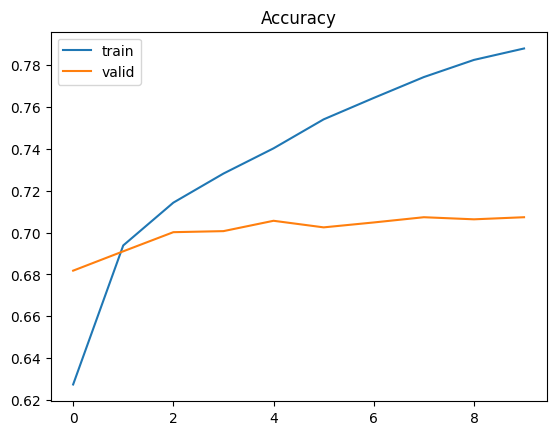

In [33]:
plot_history(language_model_history)

In [34]:
def get_predictions(model: torch.nn.Module, dataloader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, sentiment in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            preds = model(input_ids, attention_mask)

            preds = preds.cpu().detach().numpy()
            sentiment = sentiment.cpu().detach().numpy()

            preds = np.argmax(preds, axis=1).flatten().tolist()
            sentiment = np.argmax(sentiment, axis=1).flatten().tolist()

            predictions.extend(preds)
            true_labels.extend(sentiment)

    return np.array(predictions), np.array(true_labels)

In [35]:
y_pred, y_true = get_predictions(text_sentiment_model, test_dataloader)

In [36]:
def get_classification_report(y_true, y_pred, labels):
    print(classification_report(y_true, y_pred, target_names=labels))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, normalize="true"), display_labels=labels).plot()

              precision    recall  f1-score   support

    negative       0.67      0.74      0.70      8744
     neutral       0.63      0.59      0.61      1506
    positive       0.76      0.70      0.73      9750

    accuracy                           0.71     20000
   macro avg       0.69      0.68      0.68     20000
weighted avg       0.71      0.71      0.71     20000



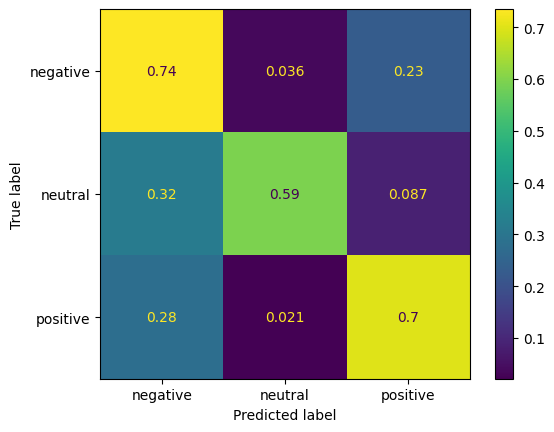

In [37]:
get_classification_report(y_true, y_pred, label_encoder.classes_)